In [1]:
using LinearAlgebra
using Plots
using Printf

push!(LOAD_PATH,".")
using SPADE


(process:14812): GLib-GIO-WARNING **: 18:44:40.619: Unexpectedly, UWP app `Microsoft.WindowsDVDPlayer_3.6.13291.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.WindowsDVDPlayer_8wekyb3d8bbwe!Microsoft.WindowsDVDPlayer') supports 1 extensions but has no verbs


Construct the grid using the SPADE package

In [2]:
#=== Problem setup ===#
𝒟x = [0.0,1.0]
𝒟y = [0.0,1.0]
nx = 41
ny = 41
Dom = Grid2D(𝒟x,𝒟y,nx,ny)

Δt = 0.01* min(Dom.Δx^2,Dom.Δy^2)
t_f = 0.05


0.05

Define the things we need for the solution with the MMS

$$
    \tilde{F}(x,y) = \sin(2\pi\omega_x x + c_x)\sin(2\pi\omega_y y + c_y)
$$
and then choose the solution
$$
    \tilde{u}(x,y,t) = \cos(2\pi t)\tilde{F}(x,y)
$$


In [3]:
cx = 1.0
cy = 0.0
ωx = 1.0
ωy = 1.0
K = 1.0


ũ(x,y,t) = cos(2π*t) * sin(2π*x*ωx + cx) * sin(2π*y*ωy + cy) #Solution

ũ₀(x,y) = sin(2π*ωx*x + cx) * sin(2π*ωy*y + cy) #Initial condition

BxLũ(y,t) = cos(2π*t) * sin(cx) * sin(2π*y*ωy + cy) #Boundary condition x=0
BxRũ(y,t) = cos(2π*t) * sin(2π*𝒟x[2]*ωx + cx) * sin(2π*y*ωy + cy) #Boundary condition x=Lx
ByLũ(x,t) = cos(2π*t) * sin(2π*x*ωx + cx) * sin(cy) #Boundary condition y=0
ByRũ(x,t) = cos(2π*t) * sin(2π*x*ωx + cx) * sin(2π*𝒟y[2]*ωy + cy) #Boundary condition y=Ly



F(x,y,t) = -2π*sin(2π*t)*sin(2π*x*ωx+cx)*sin(2π*y*ωy+cy) + 
    K * 4π^2 * (ωx^2 + ωy^2) * cos(2π*t)*sin(2π*x*ωx+cx)*sin(2π*y*ωy+cy) #F = ∂ₜũ - K∇ũ 



F (generic function with 1 method)

Plot the solution at the final time step

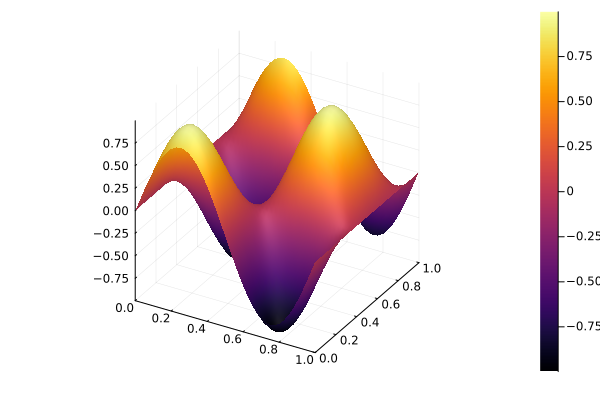

In [4]:
u_MMS = zeros(Dom.nx,Dom.ny,2)
tarry = [0.0,t_f]
for j = 1:Dom.nx; for i = 1:Dom.ny; for k = 1:length(tarry)
            u_MMS[i,j,k] = ũ(Dom.gridx[i],Dom.gridy[j],tarry[k])
        end
    end
end

surface(Dom.gridy,Dom.gridx,u_MMS[:,:,end])

Create the PDE problem in `SPADE.jl` with the source term $\tilde{u}(x,y,t)$ so we are solving the PDE

$$
    \frac{\partial u}{\partial t} - \nabla \cdot(K \nabla u) = \tilde{u}
$$

In [5]:
# Diffusion coefficients
kx = ky = zeros(Float64,nx,ny) .+ 1.0;


# Boundary conditions from the MMS
BoundaryLeft    = Boundary(Dirichlet,BxLũ,Left,1)
BoundaryRight   = Boundary(Dirichlet,BxRũ,Right,1)
BoundaryUp      = Boundary(Dirichlet,ByLũ,Up,2)
BoundaryDown    = Boundary(Dirichlet,ByRũ,Down,2)

order = 2
method = :cgie

P = VariableCoefficientPDE2D(ũ₀,kx,ky,order,BoundaryLeft,BoundaryRight,BoundaryUp,BoundaryDown);


Solve using the `SPADE.jl` package

In [6]:
soln = solve(P,Dom,Δt,t_f,:cgie,source=F);

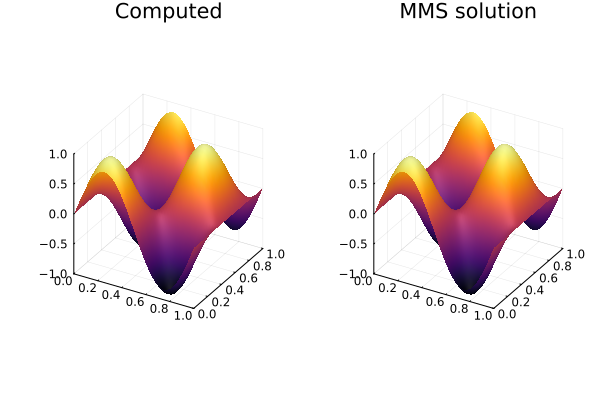

In [12]:
l2 = @layout [a b]
p2 = surface(Dom.gridy,Dom.gridx,soln.u[1],layout=l2,colorbar=false,title="Computed",zlims=(-1.0,1.0))
surface!(p2[2],Dom.gridy,Dom.gridx,u_MMS[:,:,1],colorbar=false,title="MMS solution",zlims=(-1.0,1.0))

Checking the relative error we can see its "small"

In [13]:
relerr = norm(soln.u[2] .- u_MMS[:,:,end])/norm(u_MMS[:,:,end])
@printf("Relative error ≈ %1.3f%%",relerr*100)

Relative error ≈ 4.650%

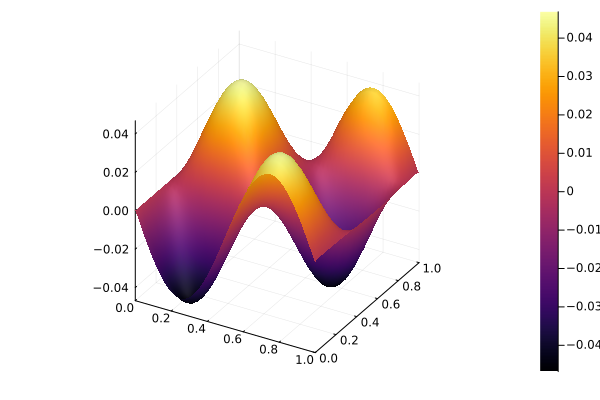

In [14]:
surface(Dom.gridy,Dom.gridx,(soln.u[2].-u_MMS[:,:,end]))